In [1]:
# import torch
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import time
import cv2
import math
import tqdm
from skimage.feature import hog
from sklearn.svm import LinearSVC
from skimage import feature as ft
from torchvision import transforms as transforms

In [2]:
## Reading & Preparing Image Data##

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def show_one_img(data,im_idx):
    im = data[im_idx].reshape((3,32,32))
    im = im.transpose(1,2,0)
    return im


Text(0.5, 1.0, 'brid')

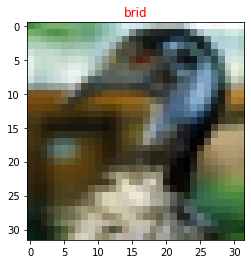

In [7]:
##Random show one pic
files = "cifar-10-python\cifar-10-batches-py"
batch_idx = random.randint(1,5)
img_idx = random.randint(0,9999)
batch = "data_batch_"+str(batch_idx)
file = os.path.join(files,batch)

batch_dict = unpickle(file)
imgs_data = batch_dict[b'data']
imgs_data = np.array(imgs_data)
imgs_label = batch_dict[b'labels']
imgs_label = np.array(imgs_label)
label_name=['airplane','automobile','brid','cat','deer','dog','frog','horse','ship','truck']

img = show_one_img(imgs_data,img_idx)
label = imgs_label[img_idx]


plt.imshow(img)
plt.title(label_name[label],color="r")


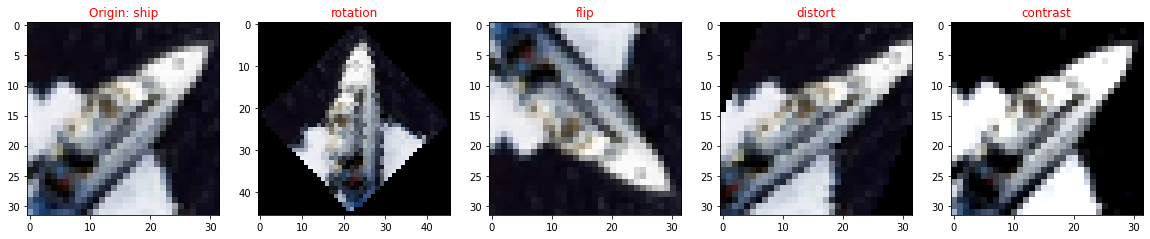

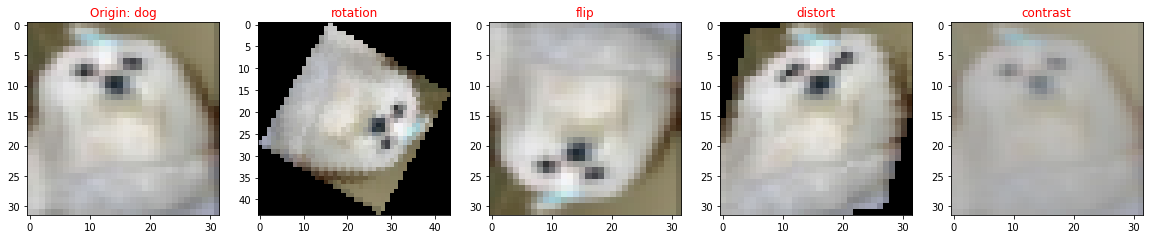

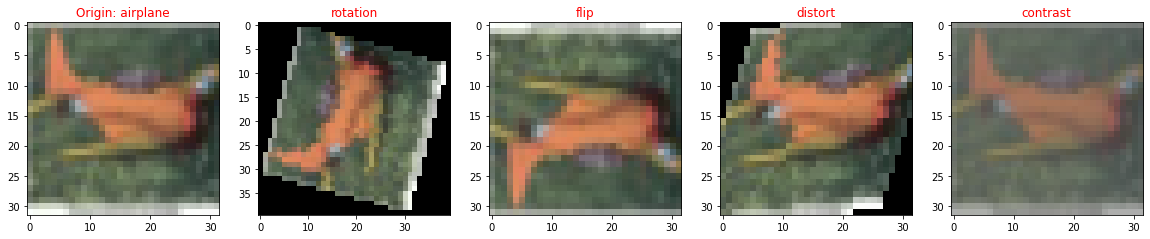

In [8]:
##Data Augmentation

for i in range(3):
    this_im = show_one_img(imgs_data,i)
    this_label = label_name[imgs_label[i]]
    this_im = Image.fromarray(this_im)
    im_flip = transforms.RandomVerticalFlip(p=1)(this_im)
    
#     angle = random.randint(0,90)
    im_rotate = transforms.RandomRotation(120, expand=True)(this_im)
    
    im_distort =transforms.RandomAffine(degrees=10, shear=(20, 30))(this_im)
    
    im_contrast = transforms.ColorJitter(contrast=1.2,saturation=1.8, hue=0)(this_im)
    plt.figure(figsize=(20, 20))  
    
    plt.subplot(3,5,i*5+1)  
    plt.imshow(this_im)
    plt.title("Origin: "+this_label,color='r')

    plt.subplot(3,5,i*5+2)  
    plt.imshow(im_rotate)
    plt.title("rotation",color='r')

    plt.subplot(3,5,i*5+3)    
    plt.imshow(im_flip)
    plt.title("flip",color='r')

    plt.subplot(3,5,i*5+4)   
    plt.imshow(im_distort)
    plt.title("distort",color='r')

    plt.subplot(3,5,i*5+5) 
    plt.imshow(im_contrast)
    plt.title("contrast",color='r')

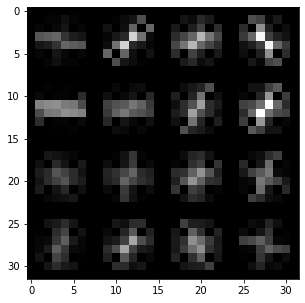

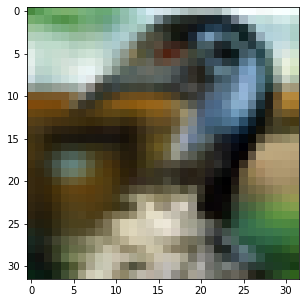

In [10]:
features = ft.hog(img,orientations=8,pixels_per_cell=(8,8),cells_per_block=(2,2),visualize=True,multichannel=True)
c=features[0]
plt.figure(figsize=(5,5))  
plt.imshow(features[1], cmap=plt.cm.gray)
plt.figure(figsize=(5,5))  
plt.imshow(img)
plt.show()

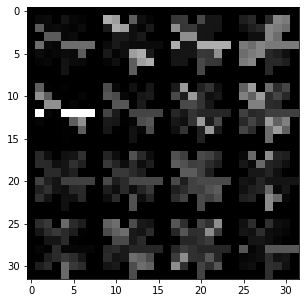

In [9]:
def get_hog_feat(image, stride=8, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    cx, cy = pixels_per_cell
    bx, by = cells_per_block
    sx, sy = image.shape
    n_cellsx = int(np.floor(sx // cx))  # number of cells in x
    n_cellsy = int(np.floor(sy // cy))  # number of cells in y
    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    eps = 1e-5
    grad = np.zeros((sx, sy, 2), dtype=np.float32)
    

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # gx[i, j] = image[i, j-1] - image[i, j+1]
            # gy[i, j] = image[i+1, j] - image[i-1, j]
            grad[i, j, 0] = np.arctan(gy[i, j] / (gx[i, j] + eps)) * 180 / math.pi
            if gx[i, j] < 0:
                grad[i, j, 0] += 180
            grad[i, j, 0] = (grad[i, j, 0] + 360) % 360
            grad[i, j, 1] = np.sqrt(gy[i, j] ** 2 + gx[i, j] ** 2)


    cell_vector = np.zeros((n_cellsy, n_cellsx, orientations))
    for i in range(n_cellsy):
        for j in range(n_cellsx):
            cell_grad = grad[i*stride:i*stride+8, j*stride:j*stride+8]
            hist = np.zeros(orientations, dtype=np.float32)
            for a in range(cy):
                for b in range(cx):
                    n = int((cell_grad[a, b, 0] % 180) / 22.5) 
                    hist[n] += cell_grad[a, b, 1]
            cell_vector[i][j] = hist[:]

    hog_image = render_gradient(np.zeros([sx,sy]), cell_vector)
    normalised_blocks = np.zeros((n_blocksy, n_blocksx, by * bx * orientations))
    for y in range(n_blocksy):
        for x in range(n_blocksx):
            block = grad[y*stride:y*stride+16, x*stride:x*stride+16]
            hist_block = np.zeros(32, dtype=np.float32)
            eps = 1e-5
            for k in range(by):
                for m in range(bx):
                    cell = block[k*8:(k+1)*8, m*8:(m+1)*8]
                    hist_cell = np.zeros(8, dtype=np.float32)
                    for i in range(cy):
                        for j in range(cx):
                            n = int((cell[i, j, 0] % 180) / 22.5)
                            hist_cell[n] += cell[i, j, 1]
                    hist_block[(k * bx + m) * orientations:(k * bx + m + 1) * orientations] = hist_cell[:]
            normalised_blocks[y, x, :] = hist_block / np.sqrt(hist_block.sum() ** 2 + eps)
    return normalised_blocks.ravel(),hog_image
 
def render_gradient(image, cell_gradient):
    cell_width = 8 / 2

    max_mag = np.array(cell_gradient).max()
    for x in range(cell_gradient.shape[0]):
        for y in range(cell_gradient.shape[1]):
            cell_grad = cell_gradient[x][y]
            cell_grad /= max_mag
            angle = 0
            angle_gap = 22.5
            
            for magnitude in cell_grad:
            
                angle_radian = math.radians(angle)
                xcent = int((x)* 8 + cell_width)
                ycent = int ((y)* 8 + cell_width)
                x1 = int(xcent + (cell_width-1)*math.cos(angle_radian))
                y1 = int(ycent + (cell_width-1) * math.sin(angle_radian))
                x2 = int(xcent - (cell_width-1) * math.cos(angle_radian))
                y2 = int(ycent - (cell_width-1) * math.sin(angle_radian))
                cv2.line(image, (y1, x1), (y2, x2), int(255 * (magnitude)))
                angle += angle_gap
    return image


from skimage import exposure
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255.
vector, image= get_hog_feat(gray)
plt.figure(figsize=(5,5))
# hog_image_rescaled = exposure.rescale_intensity(image, in_range=(0, 100))
plt.imshow(image, cmap='gray')
plt.show()

In [20]:
def get_data(filePath):
    TrainData = []
    TestData = []
    for b in range(1,6):
        f = os.path.join(filePath, 'data_batch_%d' % (b, ))
        data = unpickle(f)
        train = np.reshape(data[b'data'], (10000, 3, 32 * 32))
        labels = np.reshape(data[b'labels'], (10000, 1))
        fileNames = np.reshape(data[b'filenames'], (10000, 1))
        datalebels = zip(train, labels, fileNames)
        TrainData.extend(datalebels)
    f = os.path.join(filePath,'test_batch')
    data = unpickle(f)
    test = np.reshape(data[b'data'], (10000, 3, 32 * 32))
    labels = np.reshape(data[b'labels'], (10000, 1))
    fileNames = np.reshape(data[b'filenames'], (10000, 1))
    TestData.extend(zip(test, labels, fileNames))

    print("data read finished!")
    return TrainData, TestData

def get_feat(TrainData, TestData):
    train_feat1 = []
    test_feat1 = []
    train_feat2 = []
    test_feat2 = []
    for data in tqdm.tqdm(TestData):
        image = np.reshape(data[0].T, (32, 32, 3))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255.
        fd,_ = get_hog_feat(gray) 
        fd2 = hog(gray, 8, [8, 8], [2, 2])
        fd = np.concatenate([fd, data[1]],axis=0)
        fd2 = np.concatenate([fd2, data[1]],axis=0)
        test_feat1.append(fd)
        test_feat2.append(fd2)
    test_feat1 = np.array(test_feat1)
    test_feat2 = np.array(test_feat2)
    np.save("test_feat_my.npy", test_feat1)
    np.save("test_feat_in.npy", test_feat2)
    print("Test features are extracted and saved.")
    for data in tqdm.tqdm(TrainData):
        image = np.reshape(data[0].T, (32, 32, 3))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
        fd,_ = get_hog_feat(gray)
        fd2 = hog(gray, 8, [8, 8], [2, 2])
        fd = np.concatenate([fd, data[1]],axis=0)
        fd2 = np.concatenate([fd2, data[1]],axis=0)
        train_feat1.append(fd)
        train_feat2.append(fd2)
    train_feat1 = np.array(train_feat1)
    train_feat2 = np.array(train_feat2)
    np.save("train_feat_my.npy", train_feat1)
    np.save("train_feat_in.npy", train_feat2)
    print("Train features are extracted and saved.")
    return train_feat1, test_feat1, train_feat2, test_feat2

def classification(train_feat, test_feat):
        t0 = time.time()
        clf = LinearSVC()
        print("Training a Linear SVM Classifier.")

        train_data = train_feat[:, :-1]
        train_label =  train_feat[:, -1]
        print(train_data.shape, train_data.size)
        clf.fit(train_data, train_label)
        test_data = test_feat[:,:-1]
        test_label = test_feat[:, -1]
        predict_result = clf.predict(test_data)

        num = 0
        for i in range(len(predict_result)):
            if int(predict_result[i]) == int(test_label[i]):
                num += 1
        rate = float(num) / len(predict_result)
        t1 = time.time()
        print('The testing classification accuracy is %f' % rate)
        print('The testing cast of time is :%f' % (t1 - t0))
 
        predict_result2 = clf.predict(train_data)
        num2 = 0
        for i in range(len(predict_result2)):
            if int(predict_result2[i]) == int(train_label[i]):
                num2 += 1
        rate2 = float(num2) / len(predict_result2)
        print('The Training classification accuracy is %f' % rate2)

In [21]:
# my hog using svm
if os.path.exists("train_feat_my.npy") and os.path.exists("test_feat_my.npy"):
    train_feat = np.load("train_feat_my.npy", allow_pickle=True)
    test_feat = np.load("test_feat_my.npy", allow_pickle=True)
else:
    TrainData, TestData = get_data("cifar-10-python\cifar-10-batches-py")
    train_feat, test_feat,_,_ = get_feat(TrainData, TestData)

classification(train_feat, test_feat)


Training a Linear SVM Classifier.
(50000, 288) 14400000
The testing classification accuracy is 0.482100
The testing cast of time is :30.395329
The Training classification accuracy is 0.491480


In [23]:
# build-in hog using svm
if os.path.exists("train_feat_in.npy") and os.path.exists("test_feat_in.npy"):
    train_feat = np.load("train_feat_in.npy", allow_pickle=True)
    test_feat = np.load("test_feat_in.npy", allow_pickle=True)
else:
    TrainData, TestData = get_data("cifar-10-python\cifar-10-batches-py")
    _,_,train_feat, test_feat = get_feat(TrainData, TestData)

classification(train_feat, test_feat)

Training a Linear SVM Classifier.
(50000, 288) 14400000
The testing classification accuracy is 0.514200
The testing cast of time is :135.006826
The Training classification accuracy is 0.525540
